In [58]:
import splat
import wisps
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from os.path import expanduser
homedir = expanduser("~")
from astropy.io import ascii
%matplotlib inline
import ast

In [59]:
#get photometry catalogs
w_phot=pd.read_csv(wisps.OUTPUT_FILES+'/wisp_photometry.csv')
hst_phot=pd.read_csv(wisps.OUTPUT_FILES+'/hst3d_photometry_all.csv')

In [60]:
#w_phot.columns

In [63]:
#rename wisp grism ids
w_phot['grism_id']=w_phot['grism_id'].apply(lambda x: x.lower())
#w_phot

In [64]:
#read in the indices
cols=['name', 'snr', 'spex_chi', 'line_chi', 'spt', 'indices']
ids=pd.read_csv(homedir+'/wisp_indices.txt', names =cols, delimiter ='\t')

In [65]:
def strip_diction(s):
        #from string to dictionary
        return pd.Series(ast.literal_eval(((s.strip().replace('nan', "'nan'").replace('-inf', "'nan'")).replace('inf', "'nan'"))))

In [66]:
def reformat_index_table(df):
    #assign dictionary keys
    ids_list=[]
    snr_list=[]
    for k in df.columns:
        first=df[k].iloc[0]
        print (k)
        if isinstance(first, str):
            if first.strip().startswith("{"):
                if not k=='indices':
                    snr_list.append(df[k].apply(lambda x: strip_diction(x)))
                else:
                    ids_list.append(df[k].apply(lambda x: strip_diction(x)).applymap(tuple))
      
    
    return snr_list, ids_list

In [67]:
def replace(x):
    #print (x)
    if (isinstance(x, float)):
        if (np.isnan(x)):
            return tuple([np.nan, np.nan])
    else:
        return x

In [68]:
cols=list(wisps.INDEX_NAMES)

In [69]:
snr_list, ids_list=reformat_index_table(ids)
fmtids=(pd.concat(snr_list).join(pd.concat((ids_list )))).replace('nan', np.nan)
fmtids[cols]=fmtids[cols].applymap(lambda x: replace(x))
len(fmtids), len(ids)

name
snr
spex_chi
line_chi
spt
indices


(430413, 430413)

In [70]:
indices=fmtids
indices[['name', 'spex_chi', 'line_chi', 'spt']]=ids[['name',  'spex_chi', 'line_chi', 'spt']]

In [13]:
#hst_phot.grism_id

In [71]:
from scipy import stats
def f_test(x):
    """
    f-test statistic with defualt degrees of freedom
    """
    return stats.f.pdf(x, 2, 1, 0, scale=1)

In [72]:
def combined_wisp_hst_catalogs(hst3d_phot,wisp_phot, indices):
    """
    combine both hst-3d and wisps into one big file with all the information
    """
    #hst_3d does not have 110 photometry
    hst3d_phot['F110_mag']=np.nan
    hst3d_phot['F110_mag_er']=np.nan

    
    #combine flags into one flag
    flgs=hst3d_phot[['use_phot_x', 'f_cover', 'f_flagged', 'f_negative']].values
    hst3d_phot['phot_flags']= pd.Series([i for i in flgs])
    
    hst3d_phot['survey']='HST3D'
    wisp_phot['survey']='WISP'
    wisp_phot=wisp_phot.rename(columns={'EXTRACTION_FLAG':'phot_flags'})
   
    #rename some columns
    indices=indices.rename(columns={'name':'grism_id'})
    
    ##drop .ascii from hst_phot
    indices['grism_id']=indices['grism_id'].apply(lambda x : x.split('.1D.ascii')[0])
    
    #combined_photometry (the order matters: HST3D+WISPP
    comb_phot=pd.DataFrame()
    grism_ids=hst3d_phot['grism_id'].append(wisp_phot['grism_id'])
    star_flags=hst3d_phot['star_flag'].append(wisp_phot['star_flag'])
    comb_phot['grism_id']=grism_ids
    comb_phot['star_flag']=star_flags
    comb_phot['class_star']=hst3d_phot['class_star'].append(wisp_phot['star_flag'])
    
    print(comb_phot.columns)
    for flt in ['110', '140', '160']:
        mag_tuple1=hst3d_phot[['F'+flt+'_mag', 'F'+flt+'_mag_er']].apply(tuple, axis=1)
        mag_tuple2=wisp_phot[['NIMCOS_'+flt+'W', 'NIMCOS_'+flt+'W_ER']].apply(tuple, axis=1)
        mags=mag_tuple1.append(mag_tuple2)
        comb_phot['F'+flt]=mags
        
    ras=hst3d_phot['ra_x'].append(wisp_phot['RA'])
    decs=hst3d_phot['dec_x'].append(wisp_phot['DEC'])
        
    comb_phot['RA']=ras
    comb_phot['DEC']=decs
    comb_phot['survey']=hst3d_phot['survey'].append(wisp_phot['survey'])
    #comb_phot['flags']=hst3d_phot['flags'].append(wisp_phot['flags'])
    
    #strip white spaces from grism_ids #the combination might pose problems
    comb_phot['grism_id']=comb_phot['grism_id'].apply(lambda x: x.strip())
    indices['grism_id']=indices['grism_id'].apply(lambda x: x.strip())
    
    indices=indices.drop_duplicates(subset='grism_id')
    comb_phot=comb_phot.drop_duplicates(subset='grism_id')
    master_table=pd.merge(indices, comb_phot, on='grism_id', validate='one_to_one')
    
    # I probably lost tons of objects with grism id ='0000'
    print (master_table.shape, comb_phot.shape, indices.shape)
    #print (comb_phot.grism_id, indices.grism_id)
    #measure line and std chi-square
    #df=master_table.grism_id.apply(compare_to_both)
    #replace zeros with something close to zero to avoid dividing by zero
    master_table.line_chi[(master_table.line_chi==0.0)]=np.float(10**-40)
    ###
    master_table[['spex_chi', 'line_chi']]=master_table[['spex_chi', 'line_chi']].applymap(np.float)
    master_table['x']=master_table.spex_chi/master_table.line_chi
    master_table['f_test']=master_table.x.apply(f_test)

    #save the result
    #master_table=master_table.join(df)

    #drop the spectrum column because it makes the file heavier
    #master_table=master_table.drop(columns='spectra')

    #make the cut 

    return master_table

In [73]:
mdf=combined_wisp_hst_catalogs(hst_phot, w_phot, indices)

Index(['grism_id', 'star_flag', 'class_star'], dtype='object')
(270436, 27) (279595, 9) (430413, 19)


In [74]:
#get all the observation info for each field
obs=pd.read_csv(wisps.OUTPUT_FILES+'/observation_log.csv')
obs=obs.drop(columns=['Unnamed: 0']).drop_duplicates(subset='POINTING').reindex()

In [75]:
obs.columns=[x.lower() for x in obs.columns]

In [76]:
def get_pointing_name(grism_id):
    if grism_id.lower().startswith('par'):
        return grism_id.split('-')[0]
    else:
        return grism_id.split('-G')[0]

def add_pointing_information(row):
    #print (type(row))
    pntg=get_pointing_name(row.grism_id)
    #print (pntg)
    s3 = pd.Series({'pointing':pntg, 'exposure':obs['exposure (s)'][obs.pointing.isin([pntg])].iloc[0] })
    row=row.append(s3)
    return row

In [37]:
#

In [77]:
mt=mdf.reset_index(drop=True).apply(add_pointing_information, axis=1)

In [79]:
mt.to_hdf(wisps.COMBINED_PHOTO_SPECTRO_FILE, key='all_phot_spec_data')

In [80]:
len(mt)

270436

In [81]:
len(ids)

430413

In [42]:
#idsonly=indices[indices.snr2>5.0]
#idsonly['f']=f_test(idsonly.spex_chi.apply(float)/idsonly.line_chi.apply(float))

In [51]:
#wisps.Spectrum(filepath=wisps.REMOTE_FOLDER+'/aegis/aegis-01/1D/ASCII/aegis-01-G141_14735.1D.ascii')

In [43]:
#idsonly[idsonly.f>0.6].rename(columns={'name':'Names'}).to_hdf(wisps.COMBINED_PHOTO_SPECTRO_FILE, key='indices_only')

In [82]:
grism_ids=(wisps.datasets['candidates']['grism_id'])[wisps.datasets['candidates']['spt'].apply(splat.typeToNum) >20.].values

In [53]:
#mt['class_star']

In [83]:
(mt[['class_star', 'grism_id']])[mt.grism_id.isin(grism_ids)]

,class_star,grism_id
13277,0.03,par338-00136
13340,0.83,par338-00035
17150,0.05,par27-00036
30603,0.31,par65-00035
78946,0.42,par199-00009
98634,0.83,par156-00041
106025,0.17,par463-00176
108555,0.03,par32-00075
114500,0.03,par191-00077
116648,0.03,par201-00044


In [85]:
stars=mt[mt.class_star !=0.]

In [86]:
stars.to_hdf(wisps.COMBINED_PHOTO_SPECTRO_FILE, key='stars')

In [90]:
st=wisps.Annotator.reformat_table(stars)

In [104]:
snrs=(st[st.F140.between(24.0, 26.)]).snr1
mags=(st[st.F140.between(24.0, 26.)]).F140

In [108]:
idx=np.logical_and(snrs<10., snrs>1.)

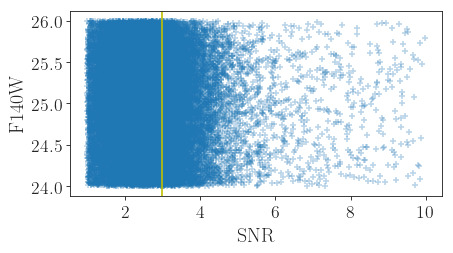

In [109]:
plt.scatter(snrs[idx], mags[idx], marker='+', alpha=0.3)
plt.xlabel('SNR')
plt.ylabel('F140W')
plt.axvline(3., c='y')